In [1]:
import os
import json

import numpy as np
import pandas as pd
import pennylane as qml

In [2]:
import git
repo = git.Repo('.', search_parent_directories=True)
repo_path = repo.working_tree_dir

In [3]:
folder_path = os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\qml.expval\Adaptive-VQE\StatevectorFiles-Overlap\AHO")
file_paths = os.listdir(folder_path)

In [4]:
json_files = [f for f in file_paths if f.endswith('.json')]
json_files

['AHO_16.json',
 'AHO_2.json',
 'AHO_32.json',
 'AHO_4.json',
 'AHO_64.json',
 'AHO_8.json']

########################################################################
Finding optimal circuit for AHO - cutoff 16
Exact eigenvalue: -0.0011669756805109488
Closest energy: -0.0011669756805193876
Gate sequence: [{'name': 'RY', 'param': 0.04182329177659544, 'wires': [2]}, {'name': 'RY', 'param': -0.07413948681396952, 'wires': [1]}, {'name': 'RY', 'param': -0.4405882080913314, 'wires': [3]}, {'name': 'CRY', 'param': -0.31517141167279256, 'wires': [3, 2]}, {'name': 'CRY', 'param': -0.15650571120691642, 'wires': [3, 1]}, {'name': 'CRY', 'param': 0.006035267898690056, 'wires': [2, 1]}, {'name': 'CRY', 'param': 0.7843128912288926, 'wires': [1, 2]}]
Gates needed to reach best energy: 7
Reduced circuit: [{'name': 'RY', 'param': 0.04182329177659544, 'wires': [2]}, {'name': 'RY', 'param': -0.07413948681396952, 'wires': [1]}, {'name': 'RY', 'param': -0.4405882080913314, 'wires': [3]}, {'name': 'CRY', 'param': -0.31517141167279256, 'wires': [3, 2]}, {'name': 'CRY', 'param': -0.15650571120691642, 

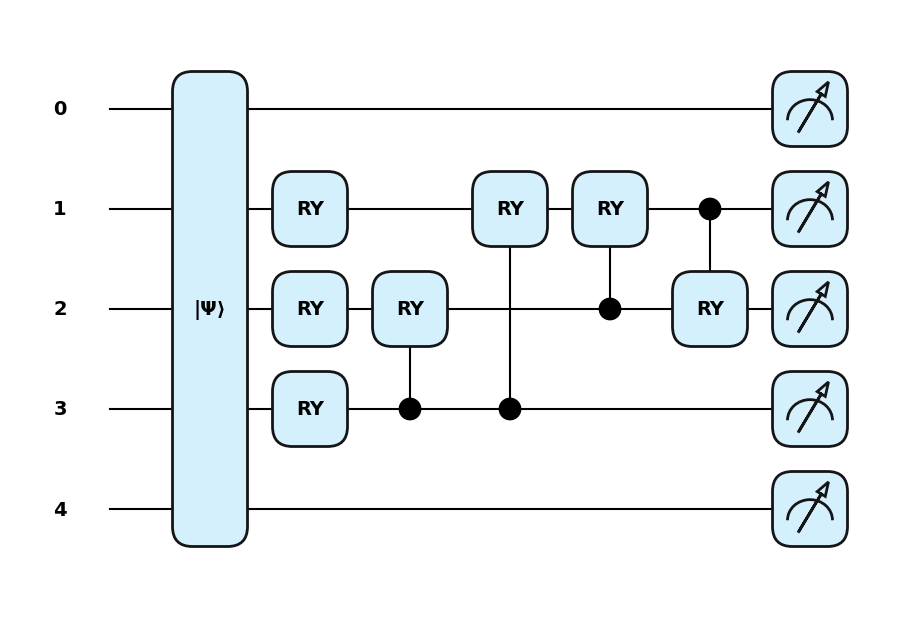

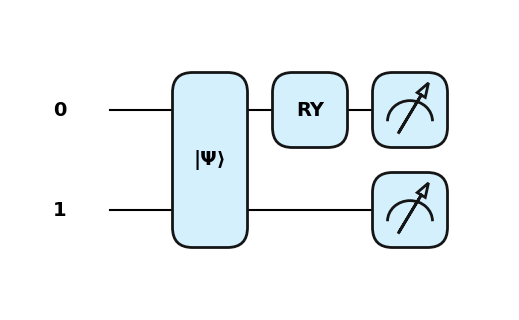

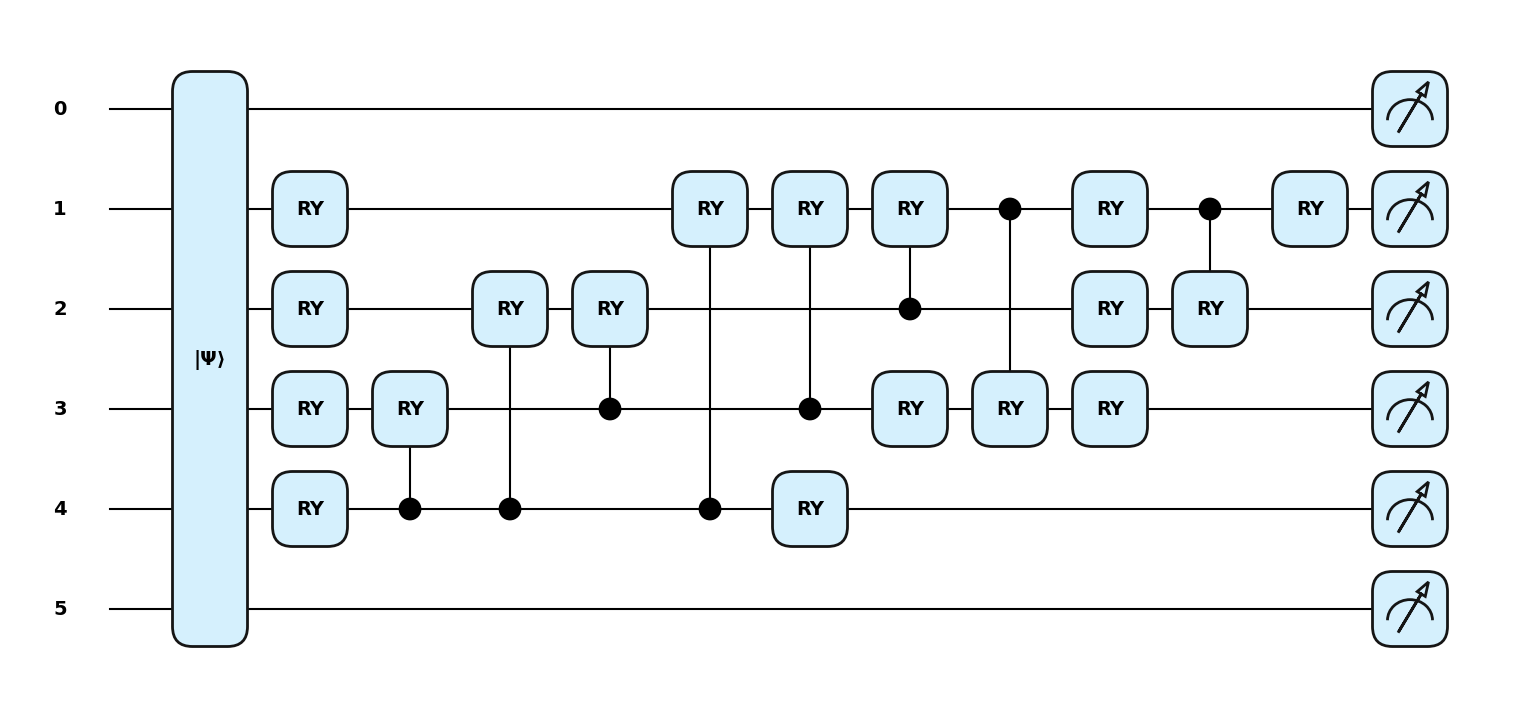

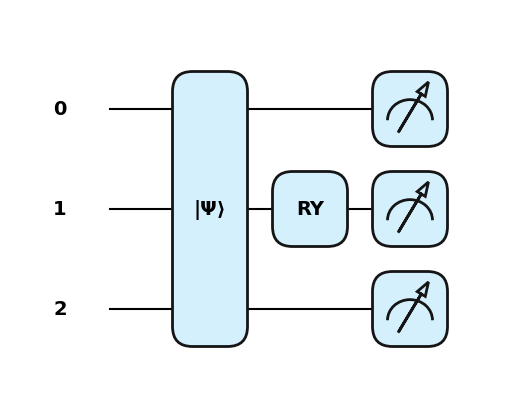

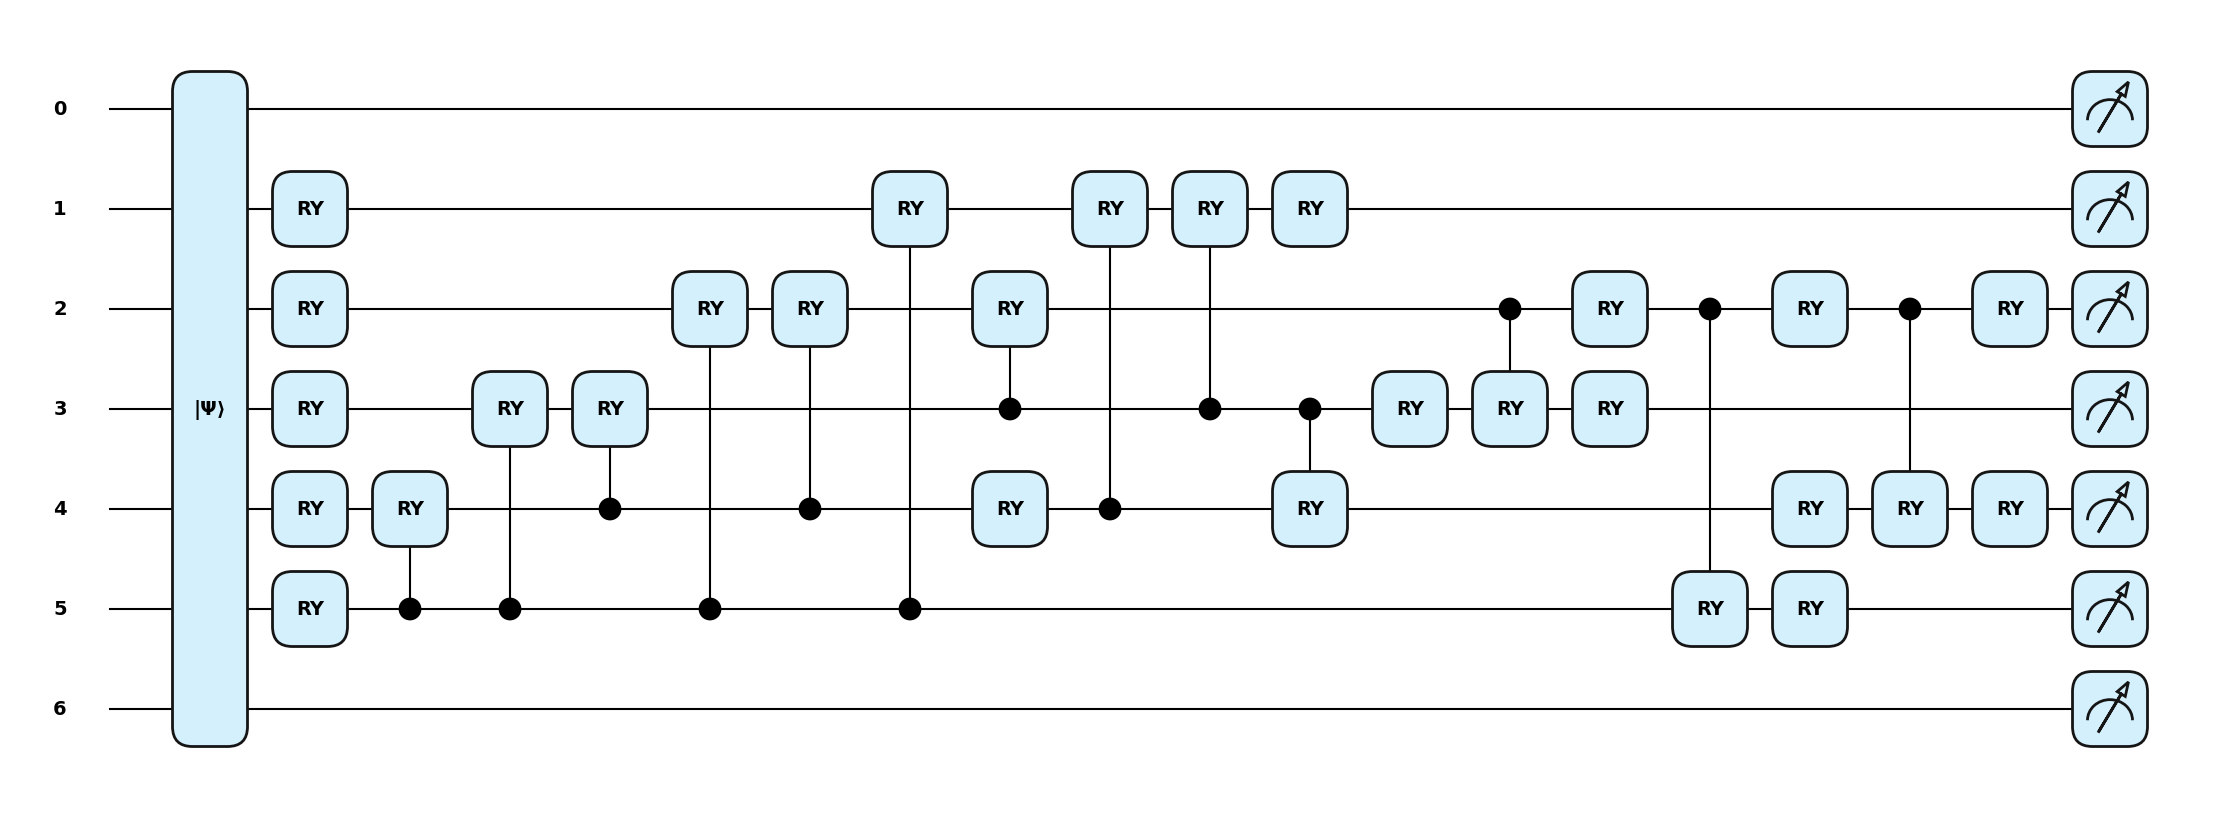

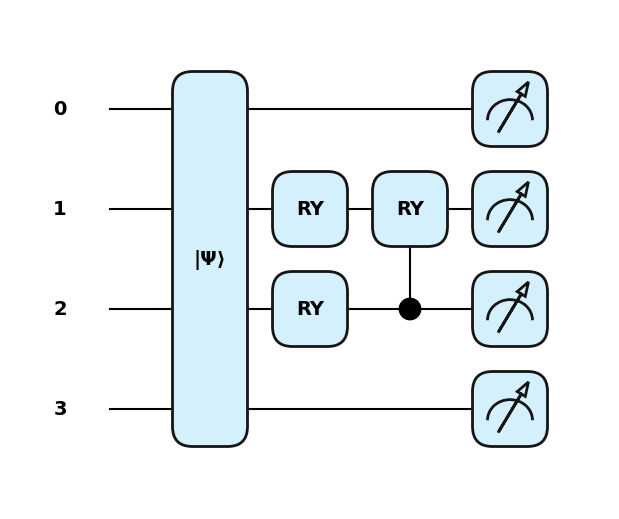

In [7]:
for file in json_files:
    
    data_path = os.path.join(folder_path,file)
    data_dict = {}

    with open(data_path, 'r') as file:
            data = json.load(file)

    cutoff = data['cutoff']
    potential = data['potential']
    energies = data['all_energies']
    overlaps = data['all_overlaps']

    print("########################################################################")
    print(f"Finding optimal circuit for {potential} - cutoff {cutoff}")

    num_qubits = int(np.log2(cutoff)) + 1
    min_eigenvalue = min(data['exact_eigenvalues'])

    closest_e = np.inf
    best_index = 0
    gate_length = np.inf
    best_energy_value = None
    best_gate_position = None

    for i, e1 in enumerate(energies):
        for g_idx, e2 in enumerate(e1, start=1):  
            ediff = abs(e2 - min_eigenvalue)

            #if (np.abs(ediff - closest_e)) < 1e-5:
            #    print("Energy same as previous.. exiting")
            #    break

            # if closer OR equal but with fewer gates
            if ediff < closest_e or ((np.abs(ediff - closest_e) < 1e-6) and g_idx < gate_length):
            #if ediff < closest_e or (ediff == closest_e and g_idx < gate_length):
                closest_e = ediff
                best_index = i
                gate_length = g_idx
                best_energy_value = e2
                best_gate_position = g_idx

            #if ediff < 1e-5:
            #    print("Found groundstate.. exiting")
            #   break

    best_gate_set = data['op_list'][best_index]
    best_gate_set_reduced = data['op_list'][best_index][:best_gate_position]

    best_energy_list = energies[best_index]
    best_energy_list_reduced = energies[best_index][:best_gate_position]

    best_overlaps = overlaps[best_index][:best_gate_position]

    print(f"Exact eigenvalue: {min_eigenvalue}")
    print(f"Closest energy: {best_energy_value}")
    print(f"Gate sequence: {best_gate_set}")
    print(f"Gates needed to reach best energy: {best_gate_position}")
    print(f"Reduced circuit: {best_gate_set_reduced}")
    print(f"Energy list for best circuit: {best_energy_list_reduced}")
    print(f"Overlaps: {best_overlaps}")


    basis_state = data["basis_state"]
    best_circuit = best_gate_set[:best_gate_position]

    data_dict = {}
    data_dict['potential'] = potential
    data_dict['cutoff'] = cutoff
    data_dict['basis_state'] = basis_state
    data_dict['min_eigenvalue'] = min_eigenvalue
    data_dict['best_energy_value'] = best_energy_value
    data_dict['best_energy_list_reduced'] = best_energy_list_reduced
    data_dict['best_overlaps'] = best_overlaps
    data_dict['circuit'] = best_circuit

    file_path = os.path.join(folder_path, f"data_{cutoff}.txt")

    with open(file_path, "w") as file:
        json.dump(data_dict, file, indent=4)

    # Define the device
    dev = qml.device("default.qubit", wires=num_qubits)


    @qml.qnode(dev)
    def circuit():

        qml.BasisState(basis_state, wires=range(num_qubits))

        for op_dict in best_circuit:
            op = getattr(qml, op_dict["name"])
            op(op_dict['param'], wires=op_dict['wires'])

        return qml.state()

    circuit_diagram = qml.draw(circuit)()
    mpl_diagram, ax = qml.draw_mpl(circuit, style='pennylane')()

    diagram_path = os.path.join(folder_path, "circuitDiagrams")
    os.makedirs(diagram_path, exist_ok=True)
    mpl_diagram.savefig(diagram_path + f"\\{potential}_{cutoff}.png")


    with open(file_path, "a", encoding="utf-8") as file:
        file.write("\n###############################\n")
        file.write(circuit_diagram)
        file.write("\n###############################\n")


########################################################################
Finding optimal circuit for AHO - cutoff 32
7.962472698074357e-06 1.7802346306079265e-06
6.1843348340067044e-06 2.0967665402738976e-09
6.415462972336739e-06 2.3322490487030885e-07
7.221116446357633e-06 1.0388783788912028e-06
6.440946302222503e-06 2.5870823475607237e-07
8.525625369916104e-06 2.343387302449673e-06
6.319383574072034e-06 1.371455066056036e-07
7.010853475791636e-06 8.286154083252056e-07
7.0339225742794544e-06 8.516845068130239e-07
6.252119811945694e-06 6.988174447926375e-08
7.695911358497929e-06 1.513673291031498e-06
6.613900021143753e-06 4.3166195367732225e-07
6.259116849949495e-06 7.687878248306412e-08
6.184558828398226e-06 2.320760931795416e-09
7.283184740944098e-06 1.1009466734776674e-06
7.1214614945960755e-06 9.39223427129645e-07
6.237993105670452e-06 5.575503820402156e-08
6.214762279272502e-06 3.252421180607123e-08
7.612771321328276e-06 1.4305332538618454e-06
7.762953201464606e-06 1.5807151339981

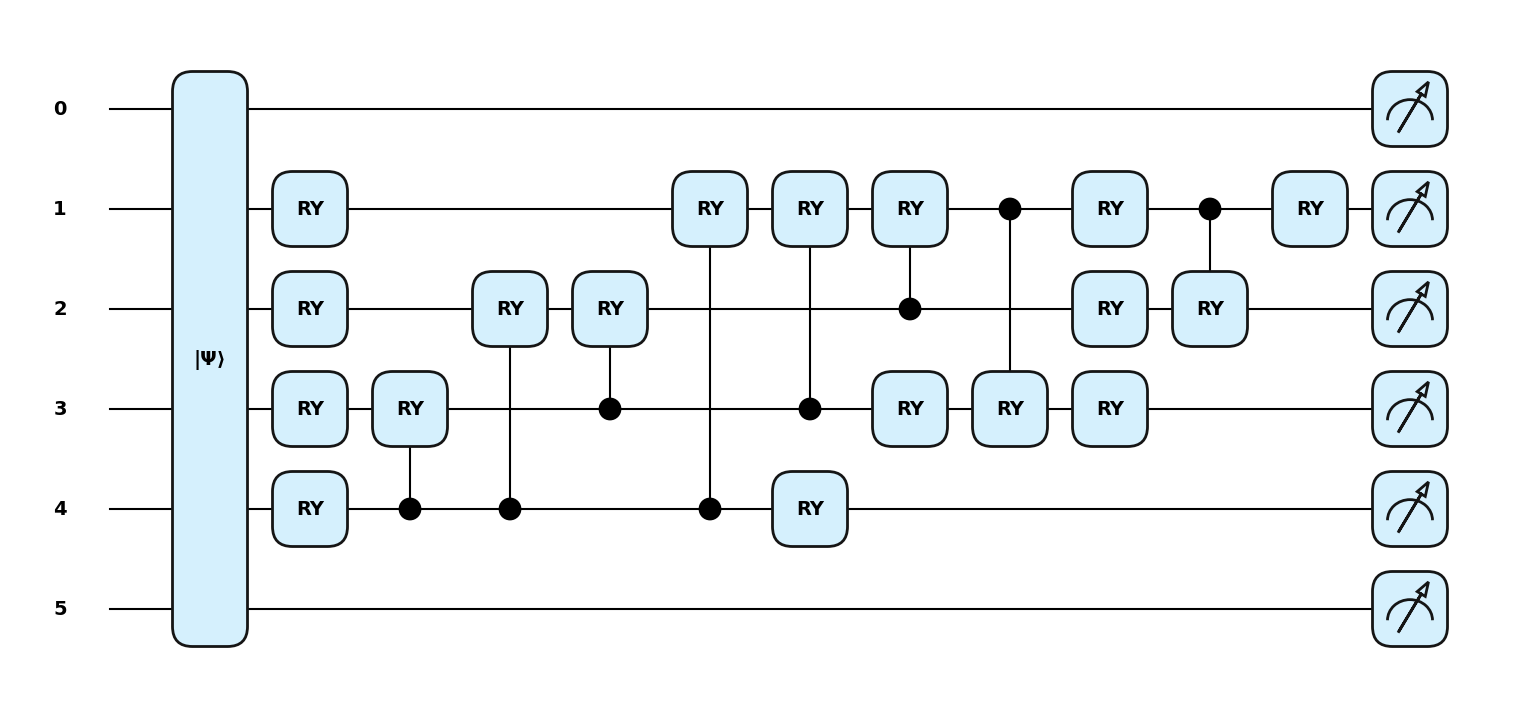

In [6]:
    
data_path = r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\COBYQA\qml.expval\Adaptive-VQE\StatevectorFiles-Overlap\AHO\AHO_32.json"

with open(data_path, 'r') as file:
        data = json.load(file)

cutoff = data['cutoff']
potential = data['potential']
energies = data['all_energies']
overlaps = data['all_overlaps']

print("########################################################################")
print(f"Finding optimal circuit for {potential} - cutoff {cutoff}")

num_qubits = int(np.log2(cutoff)) + 1
min_eigenvalue = min(data['exact_eigenvalues'])

closest_e = np.inf
best_index = 0
gate_length = np.inf
best_energy_value = None
best_gate_position = None

for i, e1 in enumerate(energies):
    for g_idx, e2 in enumerate(e1, start=1):  

        ediff = abs(e2 - min_eigenvalue)

        if e2 < 9e-6:
             print(e2, ediff)

        #if (np.abs(ediff - closest_e)) < 1e-5:
        #    print("Energy same as previous.. exiting")
        #    break

        # if closer OR equal but with fewer gates
        if ediff < closest_e or ((np.abs(ediff - closest_e) < 1e-6) and g_idx < gate_length):
        #if ediff < closest_e or (ediff == closest_e and g_idx < gate_length):
            closest_e = ediff
            best_index = i
            gate_length = g_idx
            best_energy_value = e2
            best_gate_position = g_idx

        #if ediff < 1e-5:
        #    print("Found groundstate.. exiting")
        #   break

best_gate_set = data['op_list'][best_index]
best_gate_set_reduced = data['op_list'][best_index][:best_gate_position]

best_energy_list = energies[best_index]
best_energy_list_reduced = energies[best_index][:best_gate_position]

best_overlaps = overlaps[best_index][:best_gate_position]


print(f"Exact eigenvalue: {min_eigenvalue}")
print(f"Closest energy: {best_energy_value}")
print(f"Gate sequence: {best_gate_set}")
print(f"Gates needed to reach best energy: {best_gate_position}")
print(f"Reduced circuit: {best_gate_set_reduced}")
print(f"Energy list for best circuit: {best_energy_list_reduced}")
print(f"Overlaps: {best_overlaps}")


basis_state = data["basis_state"]
best_circuit = best_gate_set[:best_gate_position]

data_dict = {}
data_dict['potential'] = potential
data_dict['cutoff'] = cutoff
data_dict['basis_state'] = basis_state
data_dict['min_eigenvalue'] = min_eigenvalue
data_dict['best_energy_value'] = best_energy_value
data_dict['best_energy_list_reduced'] = best_energy_list_reduced
data_dict['best_overlaps'] = best_overlaps
data_dict['circuit'] = best_circuit

file_path = os.path.join(folder_path, f"data_{cutoff}.txt")

with open(file_path, "w") as file:
    json.dump(data_dict, file, indent=4)

# Define the device
dev = qml.device("default.qubit", wires=num_qubits)


@qml.qnode(dev)
def circuit():

    qml.BasisState(basis_state, wires=range(num_qubits))

    for op_dict in best_circuit:
        op = getattr(qml, op_dict["name"])
        op(op_dict['param'], wires=op_dict['wires'])

    return qml.state()

circuit_diagram = qml.draw(circuit)()
mpl_diagram, ax = qml.draw_mpl(circuit, style='pennylane')()

diagram_path = os.path.join(folder_path, "circuitDiagrams")
os.makedirs(diagram_path, exist_ok=True)
mpl_diagram.savefig(diagram_path + f"\\{potential}_{cutoff}.png")


with open(file_path, "a", encoding="utf-8") as file:
    file.write("\n###############################\n")
    file.write(circuit_diagram)
    file.write("\n###############################\n")
